#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 1.환경설정

### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
def calculate_confidence_interval(accuracy, n, confidence_level=0.95):
    """
    정확도와 샘플 수를 기반으로 신뢰 구간을 계산하는 함수.

    Parameters:
    - accuracy: 모델의 정확도 (0 ~ 1)
    - n: 샘플 수 (검증 데이터 또는 테스트 데이터 샘플 수)
    - confidence_level: 신뢰 수준 (기본값 95%)

    Returns:
    - (lower_bound, upper_bound): 신뢰 구간의 하한과 상한
    """
    # 신뢰 수준에 따른 z 값 계산 (95% 신뢰 구간의 z 값: 1.96)
    z = stats.norm.ppf(1 - (1 - confidence_level) / 2)

    # 신뢰 구간 계산
    interval_margin = z * np.sqrt((accuracy * (1 - accuracy)) / n)
    lower_bound = accuracy - interval_margin
    upper_bound = accuracy + interval_margin

    return lower_bound, upper_bound

### (3) 데이터 불러오기

#### 1) 데이터로딩

In [ ]:
file1 = 'data01_train.csv'
file2 = 'data01_test.csv'

data = pd.read_csv(path + file1)
test = pd.read_csv(path + file2)

# 불필요한 칼럼 삭제
data.drop('subject', axis=1, inplace=True)
test.drop('subject', axis=1, inplace=True)

#### 2) 기본 정보 조회

In [ ]:
#전체 데이터의 행,열 개수 확인
data.shape

(5881, 562)

In [ ]:
#전체 데이터의 상위 5개 행 확인
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [ ]:
#전체 데이터의 수치형 변수 분포 확인
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


## 2.데이터 전처리

### (1) 1단계 모델링을 위한 레이블

In [ ]:
# 레이블
label = {'STANDING': 0,
         'SITTING': 0,
         'LAYING': 0,
         'WALKING': 1,
         'WALKING_UPSTAIRS': 1,
         'WALKING_DOWNSTAIRS': 1 }

# activity 값에 따라 레이블 추가
data['is_dynamic'] = data['Activity'].map(label)

data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1


### (2) x, y 분리

In [ ]:
x = data.drop(['Activity', 'is_dynamic'], axis=1)
y = data.loc[:, 'is_dynamic']

### (3) 스케일링


In [ ]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

### (4) 데이터 분할
* train, val 분할

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, random_state=1, test_size=0.2)

## **3.단계별 모델링**

### (1) 단계1

#### 1) 모델1

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │          17,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,017 (70.38 KB)

 Trainable params: 18,017 (70.38 KB)

 Non-trainable params: 0 (0.00 B)

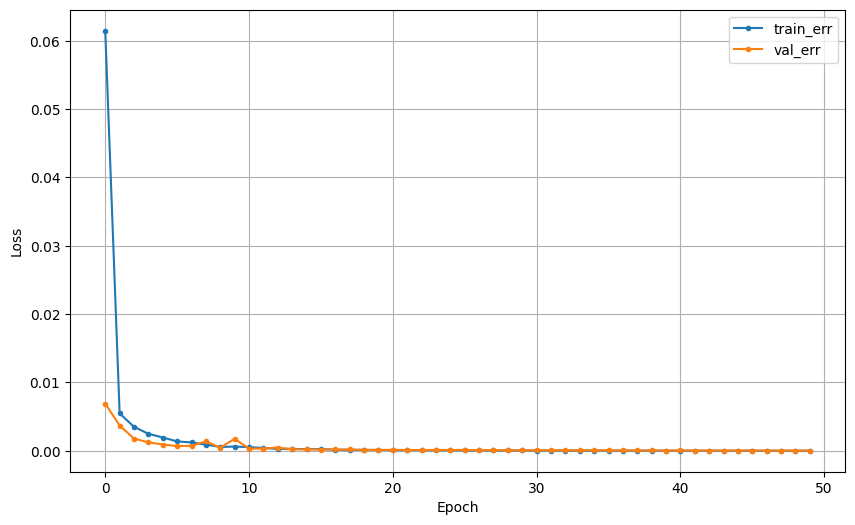

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[654   1]
 [  0 522]]
accuracy : 0.9991503823279524
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       655
           1       1.00      1.00      1.00       522

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177

confidence interval:(0.9974858698406152, 1.0008148948152897)


In [ ]:
clear_session()
model1 = Sequential([Input(shape=(x_train.shape[1],)),
                     Dense(32, activation = 'relu'),
                     Dense(1, activation = 'sigmoid')])

model1.summary()

model1.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])

hist = model1.fit(x_train, y_train, epochs = 50, validation_split = 0.2, verbose=False).history

dl_history_plot(hist)

pred1 = model1.predict(x_val)
pred1 = np.where(pred1 > 0.5, 1, 0)  # 확률이 0.5보다 크면 클래스 1로, 그렇지 않으면 클래스 0으로 예측합니다.

print('=' * 60)
print(confusion_matrix(y_val, pred1))
print('=' * 60)
accuracy = accuracy_score(y_val, pred1)
print(f'accuracy : {accuracy}')
print('=' * 60)
print(classification_report(y_val, pred1))
print('=' * 60)
confidence_interval=calculate_confidence_interval(accuracy,len(x_val))
print(f'confidence interval:{confidence_interval}')

### (2) 단계2 - 동적,정적 행동 구분

In [ ]:
train_df2=pd.read_csv('/content/drive/MyDrive/project3/data01_train.csv')
test_df2=pd.read_csv('/content/drive/MyDrive/project3/data01_test.csv')
feature_df2=pd.read_csv('/content/drive/MyDrive/project3/features.csv')
train_df2.drop('subject',axis=1,inplace=True)
test_df2.drop('subject',axis=1,inplace=True)

In [ ]:
# 동적 행동에 해당하는 값들
dynamic_activities = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']
# 정적 행동에 해당하는 값들
static_activities = ['STANDING', 'SITTING', 'LAYING']

# 'Activity' 열에서 동적 행동 데이터만 추출 (train 데이터)
df_dynamic_train = train_df2[train_df2['Activity'].isin(dynamic_activities)]
# 'Activity' 열에서 정적 행동 데이터만 추출 (train 데이터)
df_static_train = train_df2[train_df2['Activity'].isin(static_activities)]

# 'Activity' 열에서 동적 행동 데이터만 추출 (test 데이터)
df_dynamic_test = test_df2[test_df2['Activity'].isin(dynamic_activities)]
# 'Activity' 열에서 정적 행동 데이터만 추출 (test 데이터)
df_static_test = test_df2[test_df2['Activity'].isin(static_activities)]

In [ ]:
#target설정
target='Activity'
dynamic_x=df_dynamic_train.drop(target,axis=1)
dynamic_y=df_dynamic_train.loc[:,target]

static_x=df_static_train.drop(target,axis=1)
static_y=df_static_train.loc[:,target]

scaler = MinMaxScaler()
dynamic_x = scaler.fit_transform(dynamic_x)
static_x = scaler.fit_transform(static_x)

encoder = LabelEncoder()
# dynamic_y와 static_y 각각 인코딩
dynamic_y = encoder.fit_transform(dynamic_y)
static_y = encoder.fit_transform(static_y)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 82,851 (323.64 KB)

 Trainable params: 82,851 (323.64 KB)

 Non-trainable params: 0 (0.00 B)

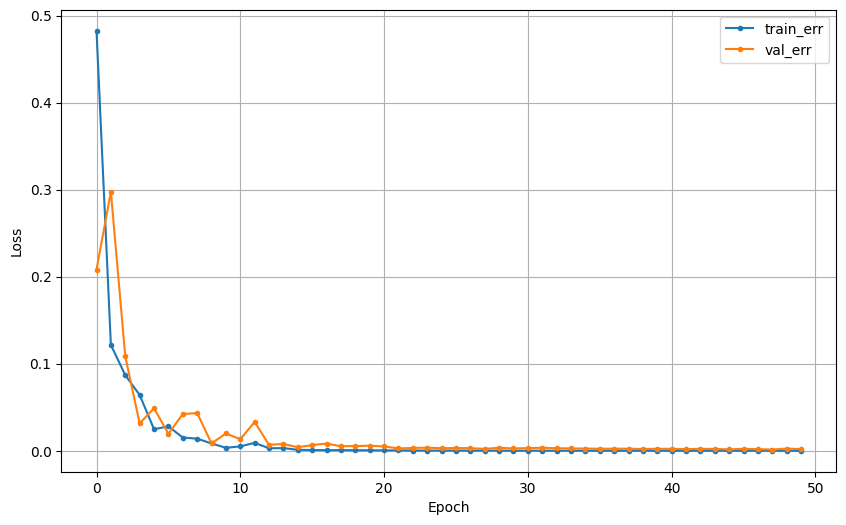

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[214   0   0]
 [  0 163   0]
 [  0   0 153]]
accuracy : 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       214
           1       1.00      1.00      1.00       163
           2       1.00      1.00      1.00       153

    accuracy                           1.00       530
   macro avg       1.00      1.00      1.00       530
weighted avg       1.00      1.00      1.00       530

(1.0, 1.0)


In [ ]:
#동적인 동작 구분하는 모델
x_train, x_val, y_train, y_val = train_test_split(dynamic_x, dynamic_y, test_size=0.2, random_state=1)

# 모델
model2= Sequential([Dense(128, activation='relu', input_shape=(x_train.shape[1], )),
                        Dense(64, activation='relu'),
                        Dense(32, activation='relu'),
                        Dense(16, activation='relu'),
                        Dense(3, activation='softmax')])

model2.summary()
model2.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

# 학습
hist = model2.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val), verbose=False).history

dl_history_plot(hist)

# 예측
pred1 = model2.predict(x_val)

# 확률을 클래스 인덱스로 변환
pred1 = np.argmax(pred1, axis=1)

print('=' * 60)
print(confusion_matrix(y_val, pred1))
print('=' * 60)
print(f'accuracy : {accuracy_score(y_val, pred1)}')
print('=' * 60)
print(classification_report(y_val, pred1))
print('=' * 60)
accuracy=accuracy_score(y_val, pred1)
print(calculate_confidence_interval(accuracy,len(x_val)))

In [ ]:
#정적인 동작 구분하는 모델
x_train2, x_val2, y_train2, y_val2 = train_test_split(static_x, static_y, test_size=0.2, random_state=1)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 512)                 │         287,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 357,635 (1.36 MB)

 Trainable params: 357,635 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

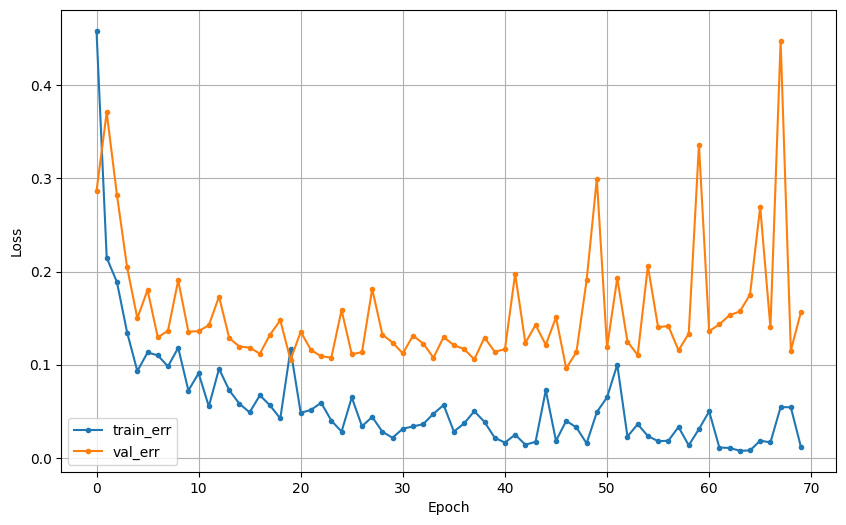

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[204   0   0]
 [  0 214   6]
 [  0  22 201]]
accuracy : 0.9567233384853169
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       204
           1       0.91      0.97      0.94       220
           2       0.97      0.90      0.93       223

    accuracy                           0.96       647
   macro avg       0.96      0.96      0.96       647
weighted avg       0.96      0.96      0.96       647

(0.9410444233222544, 0.9724022536483794)


In [ ]:
# 정적인 동작 구분하는 모델
x_train2, x_val2, y_train2, y_val2 = train_test_split(static_x, static_y, test_size=0.2, random_state=1)

# 모델 정의
model2_2 = Sequential([Input(shape=(x_train2.shape[1],)),
                     Dense(512, activation='relu'),
                     Dense(128, activation='relu'),
                     Dense(32, activation='relu'),
                     Dense(3, activation='softmax') ])
model2_2.summary()

# 모델 컴파일
model2_2.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

# 학습
hist = model2_2.fit(x_train2, y_train2, epochs=70, validation_data=(x_val2, y_val2), verbose=False).history

# 학습 결과 시각화
dl_history_plot(hist)

# 예측
pred2 = model2_2.predict(x_val2)

# 확률을 클래스 인덱스로 변환
pred2 = np.argmax(pred2, axis=1)

# 평가
print('=' * 60)
print(confusion_matrix(y_val2, pred2))
print('=' * 60)
print(f'accuracy : {accuracy_score(y_val2, pred2)}')
print('=' * 60)
print(classification_report(y_val2, pred2))
print('=' * 60)

# 정확도 계산 및 신뢰 구간 출력
accuracy = accuracy_score(y_val2, pred2)
print(calculate_confidence_interval(accuracy, len(x_val2)))

### (3) 분류 모델 파이프라인 구성


* 예시
![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들기

In [ ]:
def data_pipeline(data):
    # 경로 지정(학습된 모델 저장해서 불러온다면)
    # path = '/content/drive/MyDrive/project3/'
    data_full = data.copy()
    # 전처리, test 파일에 subject가 있다면?
    # data_full.drop('subject', axis = 1, inplace = True)
    # test DataFrame에 Activity가 있다면 Activity 지우는 구간
    data_full.drop('Activity', axis = 1, inplace = True)
    x = data_full

    # 단계1 ##########################################
    # data_full 데이터를 is_dynamic 기준으로 data_dynamic / data_static으로 나눈다
    # 스케일링
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    # 단계1 모델로 예측 시작 (model1)
    pred = model1.predict(x)
    pred = np.where(pred >= 0.5, 1, 0)
    # 단계1 예측 끝 + data_full에 붙이기
    data_full['is_dynamic'] = pred
    # data_dynamic / data_static 분리
    data_dynamic = data_full[data_full['is_dynamic'] == 1].drop('is_dynamic', axis = 1)
    data_static = data_full[data_full['is_dynamic'] == 0].drop('is_dynamic', axis = 1)

    # 단계2 #######################################

    # data_static (model2_2)
    x = scaler.transform(data_static)
    pred2_2 = model2_2.predict(x)
    pred2_2 = np.argmax(pred2_2, axis=1)
    data_static['Activity'] = pred2_2

    # data_dynamic (model2)
    x = scaler.transform(data_dynamic)
    pred2 = model2.predict(x)
    pred2 = np.argmax(pred2, axis=1)
    data_dynamic['Activity'] = pred2

    # 단계2 결과 합치기 ###########################

    # 0 / 1 / 2로 나온 결과값을 원래 Activity로 변환
    # static ==> 0 LAYING / 1 SITTING / 2 STANDING
    # dynamic ==> 0 WALKING / 1 WALKING_DOWNSTAIRS / 2 WALKING_UPSTAIRS
    data_static['Activity'] = data_static['Activity'].map({0 : 'LAYING', 1 : 'SITTING', 2 : 'STANDING'})
    data_dynamic['Activity'] = data_dynamic['Activity'].map({0 : 'WALKING', 1 : 'WALKING_DOWNSTAIRS', 2 : 'WALKING_UPSTAIRS'})

    # data_static + data_dynamic 위아래로 합치기   + 합치면서 index 번호 기준으로 재정렬
    result_data = pd.concat([data_static, data_dynamic], axis = 0)
    result_data.sort_index(inplace = True)

    ###############################################

    return result_data

In [ ]:
test_result = data_pipeline(test)
print(accuracy_score(test['Activity'], test_result['Activity']))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
0.9748470428280082


#### 2) test 셋으로 예측하고 평가하기

In [ ]:
test_result.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING
